<center><font size = "10"> Week 11 - Extracellular Response<center>
<center><font size = "8">Tutorial 04: LFPy 02 <center>

<font size='3'><font color='blue'> In this tutorial we use LFPy to calculate EEG signals from a neuron.
    
<font size='3'><font color='blue'>You can find this example in the tutorials provided by LFPy although it has been adapted to our morphologies.
    
<font size='3'><font color='blue'>Note that Noto uses LFPy version 2.0.7, not the most recent version. If you rely on the documentation for the latest version, your code will not work


<font size='3'>First step is to import LFPy and other packages for analysis and plotting:

In [1]:
import LFPy
import numpy as np
import matplotlib.pyplot as plt

<font size='3'>Define plotting functions

In [33]:
def plot_cell_to_ax(cell, ax, synidxs):
    for idx in range(cell.totnsegs):
        if idx == 0:
            ax.plot(cell.x[idx].mean(), cell.z[idx].mean(), 'ko')
        else:
            ax.plot(cell.x[idx], cell.z[idx], c='k')

    for synidx in synidxs:
        l, = ax.plot(cell.x[synidx].mean(), cell.z[synidx].mean(), '*',
                     c="r", ms=10)
    ax.legend([l], ["Synapse"], frameon=False, bbox_to_anchor=[1, -0.1])


def plot_EEG_sphere(fig, eeg, x_eeg, y_eeg, z_eeg):
    ax = fig.add_subplot(322, projection='3d',
                         title="Max EEG potential\nat 4-sphere surface")
    vmax = 6
    vmin = -vmax

    def clr(phi):
        return plt.cm.PRGn((phi - vmin) / (vmax - vmin)) 

    clrs = clr(eeg)
    print(clrs)
    print(clrs.shape)
    ax.plot_surface(x_eeg.reshape(num_theta, num_phi),
                    y_eeg.reshape(num_theta, num_phi),
                    z_eeg.reshape(num_theta, num_phi),
                    rstride=1, cstride=1, facecolors=clrs,
                    linewidth=0, antialiased=False)

    # ax.set_aspect('equal') # Raises NotImplementedError in MPL currently
    ax.axis('off')
    ax.set_xlim3d(-65000, 65000)
    ax.set_ylim3d(-65000, 65000)
    ax.set_zlim3d(-65000, 65000)
    ax.view_init(10, 0)

    # colorbar
    cax = fig.add_axes([0.65, 0.75, 0.25, 0.01])
    m = plt.cm.ScalarMappable(cmap=plt.cm.PRGn)
    ticks = np.linspace(vmin, vmax, 5)  # global normalization
    m.set_array(ticks)
    cbar = fig.colorbar(m, cax=cax,
                        extend='both', orientation='horizontal')
    cbar.outline.set_visible(False)
    cbar.set_ticks(ticks)
    cbar.set_label(r'$\phi$ (pV)', labelpad=1.)

<font size='3'> The EEG calculation is based on a four-sphere head model; the scalp, skull, CSF, and brain are represented by concentric spheres with different conductivities. This means that the influence of tissue geometry on the EEG signal is ignored.
    
Here, we define the parameters for the 4-sphere model

In [3]:
# four_sphere properties
radii = np.array([79000, 80000, 85000, 90000])
sigmas = [0.3, 1.5, 0.015, 0.3]
rad_tol = 1e-2

# simulate cell
syn_loc = (0, 0, 1000)

<font size='3'> Here, we define cell parameters

In [4]:
cellParameters = {
    'morphology' : 'Pyr_01.swc',
    'tstart' : -50,
    'tstop' : 100,
    'dt' : 2**-4,
    'passive' : True,
}

synapseParameters = {
    'syntype' : 'Exp2Syn',
    'e' : 0.,
    'tau1' : 0.5,
    'tau2' : 2.0,
    'weight' : 0.05,
    'record_current' : True,
}

In [5]:
# create cell with parameters in dictionary
cell = LFPy.Cell(**cellParameters)
pos = syn_loc
synapseParameters['idx'] = cell.get_closest_idx(x=pos[0], y=pos[1], z=pos[2])
synapse = LFPy.Synapse(cell, **synapseParameters)
synapse.set_spike_times(np.array([5.]))

cell.simulate(rec_imem=True,rec_vmem=True)


error Pyr_01.swc line 12052: could not parse: 


<font size='3'> The contribution from a single cell is modelled as a current dipole (that is, the sum of the position vectors for each neural segment, scaled by the transmembrane current from that segment). Typically, the dipole is aligned with the main axis of the pyramidal neuron, because the apical dendrites act as a current sink, and the basal dendrites/soma as a current source. 
    
Because the dipole is located at the soma, we must assume that the EEG electrodes are far enough from the cell such that the size of the cell is negligible.

In [6]:
# compute dipole
P= LFPy.get_current_dipole_moment(np.c_[cell.xmid,cell.ymid,cell.zmid],cell.imem)
P = P[0]

<font size='3'> Here, we define the positions of the soma

In [7]:
somapos = np.array([0., 0., 77500])
r_soma_syns = [
    cell.get_intersegment_vector(
        idx0=0,
        idx1=i) for i in cell.synidx]
r_mid = np.average(r_soma_syns, axis=0)
r_mid = somapos + r_mid / 2.

<font size='3'> Here, we create the 4 sphere model object, and calculate the potential created by the current dipole, at one point on the sphere

In [8]:
eeg_coords_top = np.array([[0., 0., radii[3] - rad_tol]])
four_sphere_top = LFPy.FourSphereVolumeConductor(radii, sigmas, eeg_coords_top)
pot_db_4s_top = four_sphere_top.calc_potential(P, r_mid)
eeg_top = np.array(pot_db_4s_top) * 1e9

<font size='3'> Here, we do the same for an electrode at the antipodal point. Subtracting the signal calculated here from the one claculated above yields an EEG signal, i.e., an electrode potential referenced to a different electrode

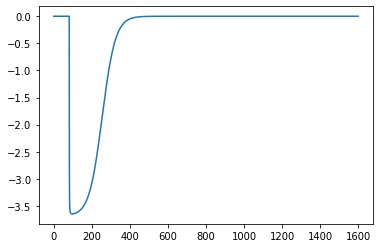

In [9]:
eeg_coords_bot = np.array([[0., -radii[3] + rad_tol,0.]])
four_sphere_bot= LFPy.FourSphereVolumeConductor(radii, sigmas, eeg_coords_bot)
pot_db_4s_bot = four_sphere_bot.calc_potential(P, r_mid)
eeg_bot = np.array(pot_db_4s_bot) * 1e9

eeg = eeg_top-eeg_bot

plt.figure()
plt.plot(eeg.T)

In [10]:
eeg_top

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.40473526e-19, -3.29998257e-19, -3.19845278e-19]])

In [11]:
eeg_bot

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.12953025e-20, 1.09477826e-20, 1.06109547e-20]])

In [12]:
# measurement points
# for nice plot use theta_step = 1 and phi_step = 1. NB: Long computation
# time.
theta_step = 5
phi_step = 5
theta, phi_angle = np.mgrid[0.:180.:theta_step,
                            0.:360. + phi_step:phi_step]

num_theta = theta.shape[0]
num_phi = theta.shape[1]
theta = theta.flatten()
phi_angle = phi_angle.flatten()

theta_r = np.deg2rad(theta)
phi_angle_r = np.deg2rad(phi_angle)

x_eeg = (radii[3] - rad_tol) * np.sin(theta_r) * np.cos(phi_angle_r)
y_eeg = (radii[3] - rad_tol) * np.sin(theta_r) * np.sin(phi_angle_r)
z_eeg = (radii[3] - rad_tol) * np.cos(theta_r)
eeg_coords = np.vstack((x_eeg, y_eeg, z_eeg)).T



In [15]:
print(phi_angle)

[  0.   5.  10. ... 350. 355. 360.]


In [27]:
eeg.shape

(1, 1601)

[[[0.96632065 0.9680892  0.96585928 1.        ]]

 [[0.96632065 0.9680892  0.96585928 1.        ]]

 [[0.96632065 0.9680892  0.96585928 1.        ]]

 ...

 [[0.96632065 0.9680892  0.96585928 1.        ]]

 [[0.96632065 0.9680892  0.96585928 1.        ]]

 [[0.96632065 0.9680892  0.96585928 1.        ]]]
(1601, 1, 4)


IndexError: index 1 is out of bounds for axis 0 with size 1

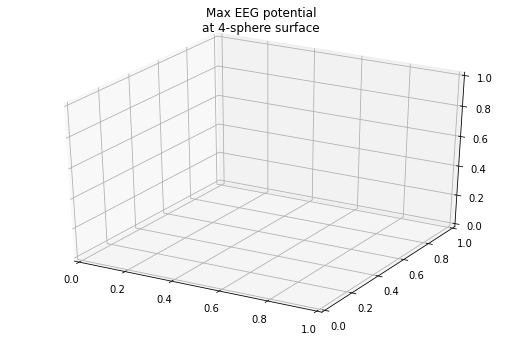

In [35]:
fig = plt.figure(figsize=(20,20))
plot_EEG_sphere(fig, eeg.T, x_eeg, y_eeg, z_eeg)